Author: A.Radhakrishnan, GFDL


In [2]:
import xarray as xr
import intake
import intake_esm
import sys
#from dask_gateway import Gateway
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.options.display.max_rows = None
import matplotlib.pyplot as plt


In [3]:
def launchDask(options):
    #TODO try, except
    gateway = Gateway()
    clusters = gateway.list_clusters()
    clusters
    if len(clusters) >0:
        cluster = gateway.connect(clusters[0].name)
        print("using existing connection")#or shut down and start afresh cluster.shutdown(). otherwise I dunno how to apply custom options
        cluster.shutdown()
        cluster = gateway.new_cluster(options)
    else:
        cluster = gateway.new_cluster(options)
    return(cluster)

In [3]:
gateway = Gateway()
options = gateway.cluster_options()
options.worker_memory=8
cluster = launchDask(options)

In [4]:
min_w = 2
max_w = 15 
cluster.adapt(minimum=min_w, maximum=max_w)

In [5]:
from distributed import Client
client = Client(cluster)
client

Client Scheduler: gateway://traefik-daskhub-dask-gateway.daskhub:80/daskhub.f939c31cbe7e4ba998a6fb0edd714717 Dashboard: /services/dask-gateway/clusters/daskhub.f939c31cbe7e4ba998a6fb0edd714717/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


ACCESS DATA FROM INTAKE CATALOG
Variables needed: Omon/tos and Ofx/areacello

esgf-world.json is the ESM collections spec file for the netCDF data in the S3 bucket esgf-world. 
The catalog is updated on an on-demand basis for now. 
You can refer to https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/esm-collection-spec-examples for the most recent catalogs
More examples can be found in https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/examples 


In [13]:
#col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/master/esm-collection-spec-examples/esgf-world.json"

In [14]:
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data 

In [15]:
def latest_version(cat):
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal_subset','source_id','table_id',
                                               'institution_id','variable_id','member_id',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat

In [16]:
query_Omon = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=['GFDL-ESM4'],
                 grid_label=['gn'],
                 variable_id=["tos"])

In [17]:
cat_Omon = col.search(**query_Omon)
cat_Omon_lat = latest_version(cat_Omon)
cat_Omon_lat = intake.open_esm_datastore(cat_Omon_lat,esmcol_data=esmcol_data)

In [18]:
dset_dict_Omon = cat_Omon_lat.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {'time': 1}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [19]:
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Ofx'],
               #  member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=['GFDL-ESM4'],
                 grid_label=['gn'],
                 variable_id=["areacello"])

cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx) 
cat_Ofx_lat = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)
dset_dict_Ofx = cat_Ofx_lat.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.table_id'


In [45]:
start="1980"
end="2011"

In [20]:
ds = dset_dict_Omon["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon"] #xarray dataset object to access Omon tos dataset

In [21]:
ds2 = dset_dict_Ofx["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Ofx"] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average

In [48]:
tos = ds.tos.sel(time=slice(start, end))

NINO3 INDEX CALCULATION 

REGION 

(5S-5N , 150W-90W) 

SELECT tos and areacello for the region of interest

In [49]:
tos = tos.where((tos.y<5) & (tos.y>-5) & (tos.x>-150) & (tos.x<-90), drop=True)

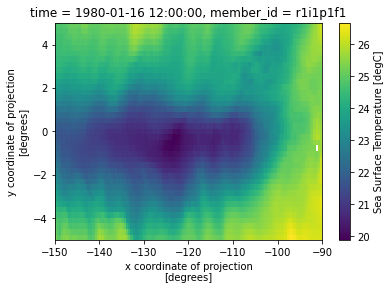

In [50]:
tos.isel(time=0).plot()

In [51]:
areacello_nino3 = ds2.areacello.where((ds2.areacello.y<5) & (ds2.areacello.y>-5) & (ds2.areacello.x>-150) & (ds2.areacello.x<-90), drop=True)

CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [52]:
total_areacello = areacello_nino34.sum(dim=('x', 'y'))
tos_mean_nino3 = (tos * areacello_nino34).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [ ]:
tos_mean_nino3.compute()

In [54]:
tos_mean_nino3.size # 32 * 12 = 384 

384

In [ ]:
datetimeindex = tos_mean_nino3.indexes['time'].to_datetimeindex()
tos_mean_nino3['time'] = datetimeindex 

CPU times: user 18.2 s, sys: 7.31 s, total: 25.5 s
Wall time: 1min 44s


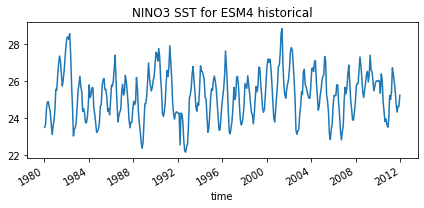

In [56]:
%%time 

tos_mean_nino3.plot(aspect=2, size=3)
plt.title("NINO3 SST for ESM4 historical")
plt.tight_layout()
plt.draw()

ADDITIONAL exploration

CLIMATOLOGY (average all Jans, Febs, etc) CALC EXAMPLES (YEARS NEED A TWEAK, calculate for 20 year chunks or as needed)

In [57]:
tos_nino3_climatology = tos.sel(time=slice(start,end)).groupby('time.month').mean(dim='time')

In [ ]:
tos_nino3_climatology.compute()

In [ ]:
tos_nino3_climatology.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [60]:
index_nino3 = (tos.groupby('time.month')-tos_nino3_climatology).mean(dim=['x','y'])

In [ ]:
index_nino3.compute()

<timed exec>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


CPU times: user 26.1 s, sys: 8.03 s, total: 34.1 s
Wall time: 2min 19s


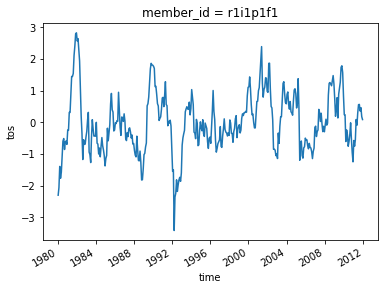

In [62]:
%%time 

datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
index_nino3['time'] = datetimeindex
index_nino3.plot()